In [49]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [50]:
file = "data/train_tweets.txt"
temp = []
with open(file, 'r') as data:
    for line in data:
        row = []
        line = line.replace('\t'," ")
        elem = line.strip().split(" ")
        row.append(elem[0])
        row.append(" ".join(elem[1:]))
        temp.append(row) 

In [51]:
tw = pd.DataFrame(temp,columns = ["User","Tweet"])
X_train, X_test, y_train, y_test = train_test_split(tw.Tweet, tw.User, random_state=0, test_size=0.3)

In [52]:
max_words = 2000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [53]:
tokenize.fit_on_texts(pd.Series(tw['Tweet'])) # only fit on train
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

In [54]:
encoder = LabelEncoder()
encoder.fit(pd.Series(tw['User']))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [55]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [56]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (230252, 2000)
x_test shape: (98680, 2000)
y_train shape: (230252, 9297)
y_test shape: (98680, 9297)


In [66]:
batch_size = 30
epochs = 50

In [67]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 207226 samples, validate on 23026 samples
Epoch 1/50
207226/207226 [==============================] - 104s 500us/step - loss: 8.5083 - acc: 0.0188 - val_loss: 8.0440 - val_acc: 0.0422
Epoch 2/50
207226/207226 [==============================] - 88s 424us/step - loss: 7.4151 - acc: 0.0713 - val_loss: 7.3786 - val_acc: 0.0862
Epoch 3/50
207226/207226 [==============================] - 86s 416us/step - loss: 6.5938 - acc: 0.1173 - val_loss: 7.0475 - val_acc: 0.1085
Epoch 4/50
207226/207226 [==============================] - 89s 429us/step - loss: 5.9886 - acc: 0.1534 - val_loss: 6.8979 - val_acc: 0.1216
Epoch 5/50
207226/207226 [==============================] - 90s 435us/step - loss: 5.5270 - acc: 0.1868 - val_loss: 6.8431 - val_acc: 0.1309
Epoch 6/50
207226/207226 [==============================] - 89s 428us/step - loss: 5.1479 - acc: 0.2191 - val_loss: 6.8263 - val_acc: 0.1376
Epoch 7/50
207226/207226 [==============================] - 91s 438us/step - loss: 4.8215 - acc: 0.249

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


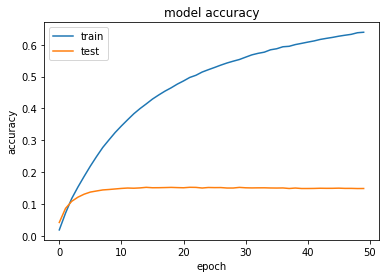

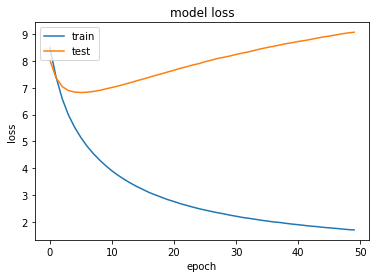

In [69]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score)

98680/98680 [==============================] - 18s 185us/step
Test accuracy: [8.971971844293156, 0.15148966339347716]


In [72]:
def prepare_test_data(tokenize):
    file1 = "data/test_tweets_unlabeled.txt"
    with open(file1, 'r') as data:
        temp = [line for line in data]    
    unlabel = pd.Series(temp)
    unlabel_en = tokenize.texts_to_matrix(unlabel)
    return unlabel_en
    
def submission_file(data):
    import csv
    with open('predicted.csv', 'w') as writeFile:
        writer = csv.writer(writeFile)
        writer.writerow(['Id','Predicted'])
        for count,predicted in enumerate(data):
            writer.writerow([count+1,predicted])

In [73]:
test_unlabel = prepare_test_data(tokenize)

In [74]:
predicted = model.predict_classes(test_unlabel)

In [79]:
submission_file(predicted)